In [105]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.text import Text
import numpy as np

In [2]:
metrics_filenames = glob.glob("*.csv")
dfs = []
for filename in metrics_filenames:
    dfs.append(pd.read_csv(filename, header=[0, 1], skipinitialspace=True, index_col=0))
metrics = pd.concat(dfs)
metrics = metrics.rename(columns={
    "max_memory (GB)": "max_memory",
    "matrix_memory (GB)": "matrix_memory",
    "execution_time (s)": "execution_time",
    "max_memory_to_use_GB": "max_memory_to_use",
})
metrics.columns = [
    "max_memory_numpy", "max_memory_numba",
    "matrix_memory_numpy", "matrix_memory_numba",
    "execution_time_numpy", "execution_time_numba",
    "embedding_dim",
    "max_memory_to_use",
    "top_k"
]
metrics.head()

,max_memory_numpy,max_memory_numba,matrix_memory_numpy,matrix_memory_numba,execution_time_numpy,execution_time_numba,embedding_dim,max_memory_to_use,top_k
n_items,,,,,,,,,
5000,0.205121,0.421123,0.2,0.00602,0.117582,0.537848,128,10,100
10000,0.810244,1.630099,0.8,0.01204,0.715076,0.977795,128,10,100
15000,1.815364,3.643701,1.8,0.01806,1.653239,1.429513,128,10,100
20000,3.220484,6.455992,3.2,0.02408,3.021997,1.839184,128,10,100
25000,5.025604,9.384092,5.0,0.03010,5.049828,2.558790,128,10,100


In [3]:
print("Embedding Dim:", metrics["embedding_dim"].unique())
print("Max Memory to Use:", metrics["max_memory_to_use"].unique())
print("Top K:", metrics["top_k"].unique())
print("Top K:", metrics.index.unique())

Embedding Dim: [128 256]
Max Memory to Use: [10 20  5]
Top K: [100]
Top K: Int64Index([   5000,   10000,   15000,   20000,   25000,   30000,   35000,
              40000,   45000,   50000,   55000,   60000,   65000,   70000,
              75000,   80000,   85000,   90000,   95000,  100000, 1000000,
             125000,  150000,  175000,  200000,  225000,  250000,  275000,
             300000,  325000,  350000,  375000,  400000,  425000,  450000,
             475000,  500000],
           dtype='int64', name='n_items')


In [139]:
small_metrics = metrics.loc[metrics.index <= 1E5]
plt.rc('legend', fontsize=11)

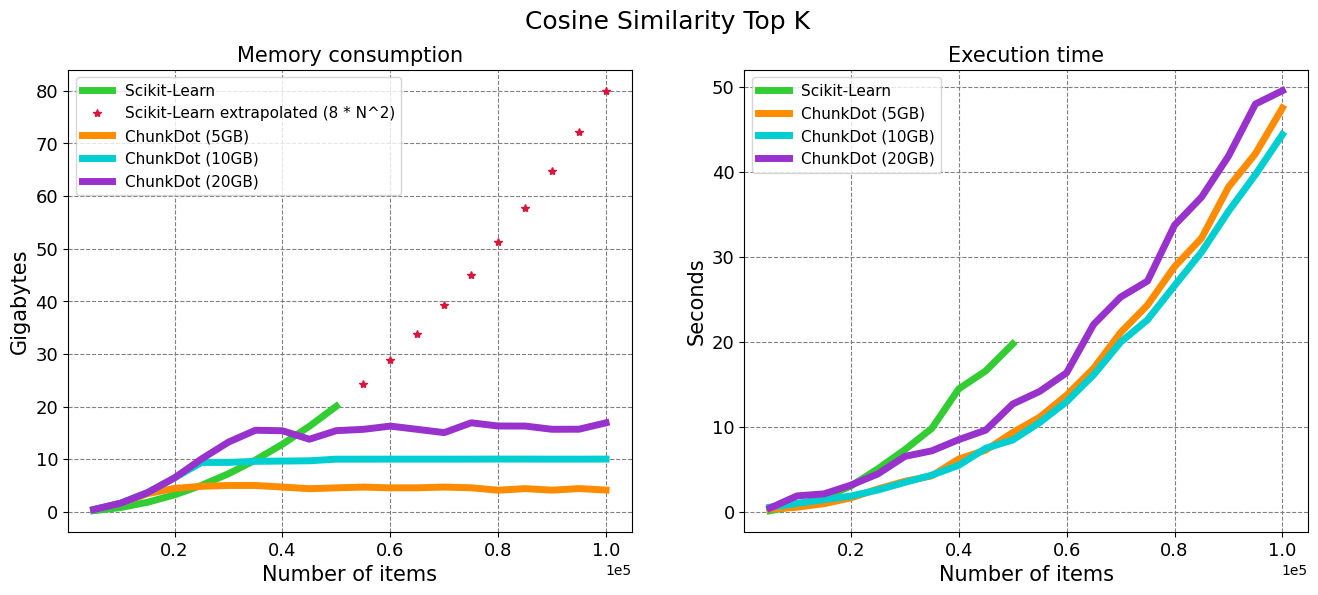

In [142]:
scikit_learn = small_metrics.loc[small_metrics["max_memory_to_use"] == 10, ["max_memory_numpy"]].rename(columns={"max_memory_numpy": "Scikit-Learn"})
scikit_learn_extrapolated = scikit_learn.copy()
scikit_learn_extrapolated["Scikit-Learn extrapolated (8 * N^2)"] =  [x ** 2 * 8 / 1E9 if x > 5E4 else None for x in scikit_learn.index]
scikit_learn_extrapolated = scikit_learn_extrapolated[["Scikit-Learn extrapolated (8 * N^2)"]]
numba_5 = small_metrics.loc[small_metrics["max_memory_to_use"] == 5, ["max_memory_numba"]].rename(columns={"max_memory_numba": "ChunkDot (5GB)"})
numba_10 = small_metrics.loc[small_metrics["max_memory_to_use"] == 10, ["max_memory_numba"]].rename(columns={"max_memory_numba": "ChunkDot (10GB)"})
numba_20 = small_metrics.loc[small_metrics["max_memory_to_use"] == 20, ["max_memory_numba"]].rename(columns={"max_memory_numba": "ChunkDot (20GB)"})
numba_20 = numba_20.groupby("n_items").mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle("Cosine Similarity Top K", fontsize=18)
linewidth = 5
label_fontsize = 15

scikit_learn.plot(ax=axes[0], linewidth=linewidth, color="limegreen")
scikit_learn_extrapolated.plot(ax=axes[0], linewidth=linewidth, color="crimson", style="*")
numba_5.plot(ax=axes[0], linewidth=linewidth, color="darkorange")
numba_10.plot(ax=axes[0], linewidth=linewidth, color="darkturquoise")
numba_20.plot(ax=axes[0], linewidth=linewidth, color="darkorchid")

axes[0].set_xlabel("Number of items", fontsize=label_fontsize)
axes[0].set_ylabel("Gigabytes", fontsize=label_fontsize)
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].set_title("Memory consumption", fontsize=15)
axes[0].yaxis.grid(color='gray', linestyle='dashed')
axes[0].xaxis.grid(color='gray', linestyle='dashed')
axes[0].tick_params(axis='both', labelsize=13)

scikit_learn = small_metrics.loc[small_metrics["max_memory_to_use"] == 10, ["execution_time_numpy"]].rename(columns={"execution_time_numpy": "Scikit-Learn"})
scikit_learn_extrapolated = scikit_learn.copy()
numba_5 = small_metrics.loc[small_metrics["max_memory_to_use"] == 5, ["execution_time_numba"]].rename(columns={"execution_time_numba": "ChunkDot (5GB)"})
numba_10 = small_metrics.loc[small_metrics["max_memory_to_use"] == 10, ["execution_time_numba"]].rename(columns={"execution_time_numba": "ChunkDot (10GB)"})
numba_20 = small_metrics.loc[(small_metrics["max_memory_to_use"] == 20) & (small_metrics.index < 1E6), ["execution_time_numba"]].rename(columns={"execution_time_numba": "ChunkDot (20GB)"})
numba_20 = numba_20.groupby("n_items").mean()

scikit_learn.plot(ax=axes[1], linewidth=linewidth, color="limegreen")
numba_5.plot(ax=axes[1], linewidth=linewidth, color="darkorange")
numba_10.plot(ax=axes[1], linewidth=linewidth, color="darkturquoise")
numba_20.plot(ax=axes[1], linewidth=linewidth, color="darkorchid")
axes[1].set_xlabel("Number of items", fontsize=label_fontsize)
axes[1].set_ylabel("Seconds", fontsize=label_fontsize)
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_title("Execution time", fontsize=15)
axes[1].yaxis.grid(color='gray', linestyle='dashed')
axes[1].xaxis.grid(color='gray', linestyle='dashed')
axes[1].tick_params(axis='both', labelsize=13)

fig.savefig('cosine_similarity_top_k-1E5.png', bbox_inches='tight')

/var/folders/cy/0x_79kf10jg3px8zkxz_9knslr3n8x/T/ipykernel_27525/667647738.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels() + [Text(0, 20.0, '20')])


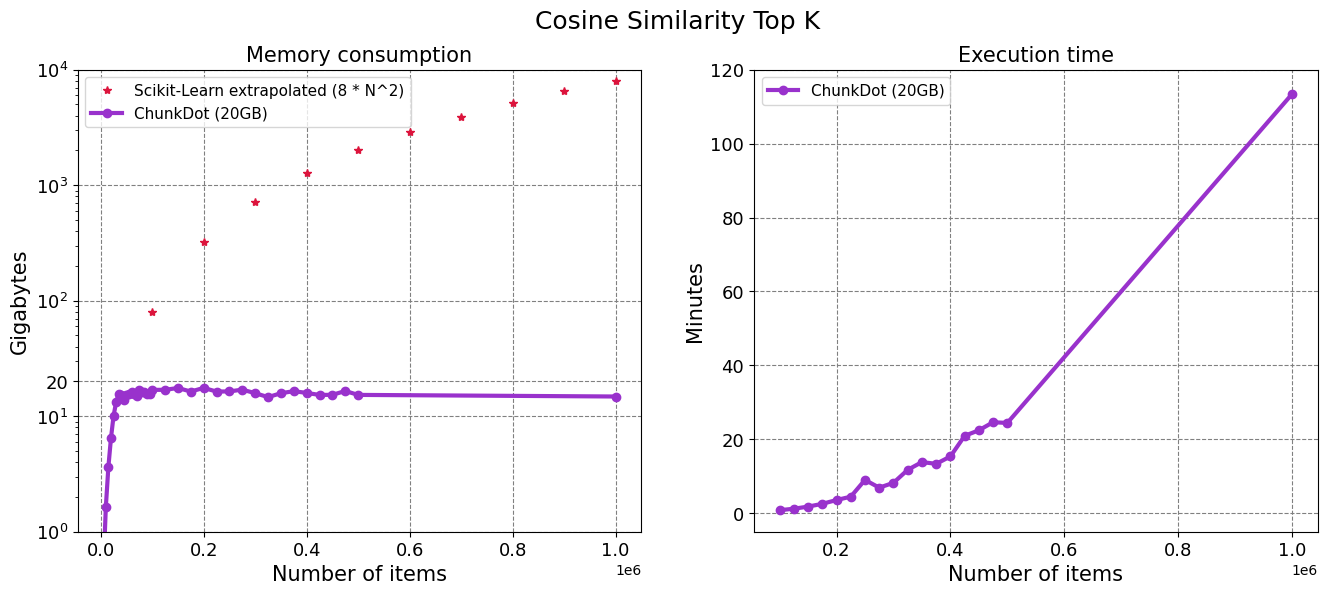

In [143]:
numba_20 = metrics.loc[metrics["max_memory_to_use"] == 20, ["max_memory_numba"]].rename(columns={"max_memory_numba": "ChunkDot (20GB)"})
numba_20 = numba_20.groupby("n_items").mean()
scikit_learn_extrapolated = pd.DataFrame(index=range(0, int(1E6) + 1, int(1E5)), data={"Scikit-Learn extrapolated (8 * N^2)": [x ** 2 * 8 / 1E9 if x > 5E4 else None for x in range(0, int(1E6) + 1, int(1E5))]})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle("Cosine Similarity Top K", fontsize=18)
linewidth = 3
label_fontsize = 15

scikit_learn_extrapolated.plot(ax=axes[0], linewidth=linewidth, color="crimson", style="*", logy=True)
numba_20.plot(ax=axes[0], linewidth=linewidth, color="darkorchid", marker="o")
axes[0].set_yticklabels(axes[0].get_yticklabels() + [Text(0, 20.0, '20')])
axes[0].set_yticks(list(axes[0].get_yticks()) + [20])
axes[0].set_xlabel("Number of items", fontsize=label_fontsize)
axes[0].set_ylabel("Gigabytes", fontsize=label_fontsize)
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[0].set_title("Memory consumption", fontsize=15)
axes[0].yaxis.grid(color='gray', linestyle='dashed')
axes[0].xaxis.grid(color='gray', linestyle='dashed')
axes[0].set_ylim(1, 1E4)
axes[0].tick_params(axis='both', labelsize=13)

numba_20 = big_metrics.loc[big_metrics["max_memory_to_use"] == 20, ["execution_time_numba"]]
numba_20["execution_time_numba"] = numba_20["execution_time_numba"] / 60
numba_20 = numba_20.rename(columns={"execution_time_numba": "ChunkDot (20GB)"})
numba_20 = numba_20.groupby("n_items").mean()

numba_20.plot(ax=axes[1], linewidth=linewidth, color="darkorchid", marker="o", ylim=(-5, 120))
axes[1].set_xlabel("Number of items", fontsize=label_fontsize)
axes[1].set_ylabel("Minutes", fontsize=label_fontsize)
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_title("Execution time", fontsize=15)
axes[1].yaxis.grid(color='gray', linestyle='dashed')
axes[1].xaxis.grid(color='gray', linestyle='dashed')
axes[1].tick_params(axis='both', labelsize=13)

fig.savefig('cosine_similarity_top_k-1E6.png', bbox_inches='tight')